# R2SFCA: Reconciled Two-Step Floating Catchment Area Model

A Python package for spatial accessibility analysis that reconciles 2SFCA and i2SFCA methods through distance decay parameterization and cross-entropy minimization.

**Authors: Lingbo Liu (Harvard University), Fahui Wang (Louisiana State University)**

**Abstract**

Understanding spatial accessibility and facility crowdedness is central to public service planning, yet existing methods often treat these two metrics separately. The Two-Step Floating Catchment Area (2SFCA) method measures accessibility from the demand side, while the inverted 2SFCA (i2SFCA) assesses crowdedness from the supply side. However, without proper integration, these two measures may diverge, raising concerns of their validity. This study introduces a distance decay parameterization framework to reconcile 2SFCA and i2SFCA by optimizing a unified distance decay function through cross-entropy minimization. We demonstrate that aligning demand-side and supply-side flows effectively enforces a behavioral equilibrium between accessibility and crowdedness. A case study using inpatient hospital flow data in Florida shows that the reconciled 2SFCA (r2SFCA) model, especially when employing a Gaussian decay function, achieves strong alignment between estimated and observed service flows while maintaining methodological simplicity. These findings validate the self-organizing nature of human service-seeking behaviors and support a unified, entropy-based calibration strategy for accessibility modeling.

# 1 Install Package

In [4]:
!pip install r2sfca

Defaulting to user installation because normal site-packages is not writeable
  Using cached r2sfca-1.1.2-py3-none-any.whl.metadata (14 kB)
Using cached r2sfca-1.1.2-py3-none-any.whl (15 kB)


In [1]:
import r2sfca
print("r2sfca version:", getattr(r2sfca, "__version__", "unknown"))

r2sfca version: 1.1.3


In [2]:
from r2sfca import DecayFunction
print(f"available decay functions: {[func.value for func in DecayFunction]}")

available decay functions: ['exponential', 'power', 'sigmoid', 'sqrt_exponential', 'gaussian', 'log_squared']


# 2 Read Examplary Data

In [3]:
import pandas as pd
# Load your spatial accessibility data
url='https://raw.githubusercontent.com/UrbanGISer/UrbanAnalytics/refs/heads/main/Accessibility/r2SFCA_data.csv.gz'
df = pd.read_csv(url)
df.head()

,DemandID,Demand,SupplyID,Supply,TravelCost,O_Fij,O_Tij
0,1,19172,1,112,0.772843,3633,61.224195
1,1,19172,13,102,30.868189,7,1.460123
2,1,19172,16,1018,26.075388,395,9.609511
3,1,19172,62,368,119.885544,1,0.015482
4,1,19172,64,349,110.510293,1,0.016492


# 3 Quick Start

## Step 1 Initialize the R2SFCA model-single Parameter

**single parameter**:exponential, power,  sqrt_exponential,  log_squared

**with 2nd parameter**: sigmoid,gaussian,

In [4]:
from r2sfca import R2SFCA
# Initialize the R2SFCA model
model = R2SFCA(
    df=df,
    demand_col='Demand',
    supply_col='Supply',
    travel_cost_col='TravelCost',
    demand_id_col='DemandID',
    supply_id_col='SupplyID',
    # observed_flow_col='O_Fij',  # Optional, for validation
    decay_function='exponential'
)

## Step 2 Solve beta by using minimize cross entropy

In [5]:
# Optimize parameters using minimize
optimization_minimize = model.solve_beta(
    metric='cross_entropy',
    method='minimize'
)

In [6]:
# print result
optimization_minimize


{'optimal_beta': 0.238165142409397,
 'param2': 1.0,
 'optimization_success': True,
 'optimization_message': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'final_metrics': {'cross_entropy': 8.545676698513681,
  'correlation': 0.7423317664031132,
  'rmse': 2473.156796277669,
  'mse': 6116504.538974423,
  'mae': 504.2664110823714},
 'fij': array([1.79684917e+04, 1.26187879e+01, 3.94369120e+02, ...,
        3.19780194e-03, 1.32659873e+03, 1.52977825e+02]),
 'tij': array([6.78453384e+01, 1.64722007e-02, 4.47529366e-01, ...,
        4.48014488e-06, 1.35312222e+00, 8.47597269e+01])}

In [41]:
print(f"Best beta: {optimization_minimize['optimal_beta']}")
print(f"cross_entropy: {optimization_minimize['final_metrics']['cross_entropy']}")
print(f"correlation: {optimization_minimize['final_metrics']['correlation']}")

Best beta: 0.238165142409397
cross_entropy: 8.545676698513681
correlation: 0.7423317664030783


## Step 3 Run 2SFCA and i2SFCA with optimal beta

In [43]:
opt_beta=optimization_minimize['optimal_beta']

In [47]:
# Calculate accessibility and crowdedness scores
accessibility = 1000*model.access_score(beta=opt_beta)
crowdedness = model.crowd_score(beta=opt_beta)

In [48]:
accessibility_df = pd.DataFrame({
    'DemandID': accessibility.index,
    'Accessibility': accessibility.values
})

crowdedness_df = pd.DataFrame({
    'SupplyID': crowdedness.index,
    'Crowdedness': crowdedness.values
})

In [49]:
accessibility_df

,DemandID,Accessibility
0,1,3.641165
1,2,0.474910
2,3,1.264439
3,4,0.238257
4,5,2.257243
...,...,...
978,979,6.619963
979,980,18.600957
980,981,4.135997
981,982,0.495246


In [50]:
crowdedness_df

,SupplyID,Crowdedness
0,1,629.640704
1,13,275.645864
2,16,301.407128
3,20,453.300595
4,22,398.939385
...,...,...
203,976,412.790088
204,978,577.332799
205,980,259.638657
206,981,674.954444


# 4 Alternative methods

## 4.1 Perform grid search to find optimal parameters



In [57]:
# Perform grid search to find optimal parameters
results = model.search_fij(
    beta_range=(0.0, 4.0, 0.2),
)

In [59]:
results

,beta,param2,decay_function,cross_entropy,correlation,rmse
0,0.0,1.0,exponential,10.300858,0.572661,739.376328
1,0.2,1.0,exponential,8.563250,0.777820,2323.077425
2,0.4,1.0,exponential,8.767924,0.631734,2919.775492
3,0.6,1.0,exponential,9.391990,0.553262,3220.639565
4,0.8,1.0,exponential,10.161999,0.507337,3388.411606
5,1.0,1.0,exponential,10.965877,0.478046,3491.347464
6,1.2,1.0,exponential,11.764524,0.457800,3559.348803
7,1.4,1.0,exponential,12.545577,0.442662,3607.327071
8,1.6,1.0,exponential,13.309840,0.430668,3643.266979
9,1.8,1.0,exponential,14.043589,0.420783,3671.547760


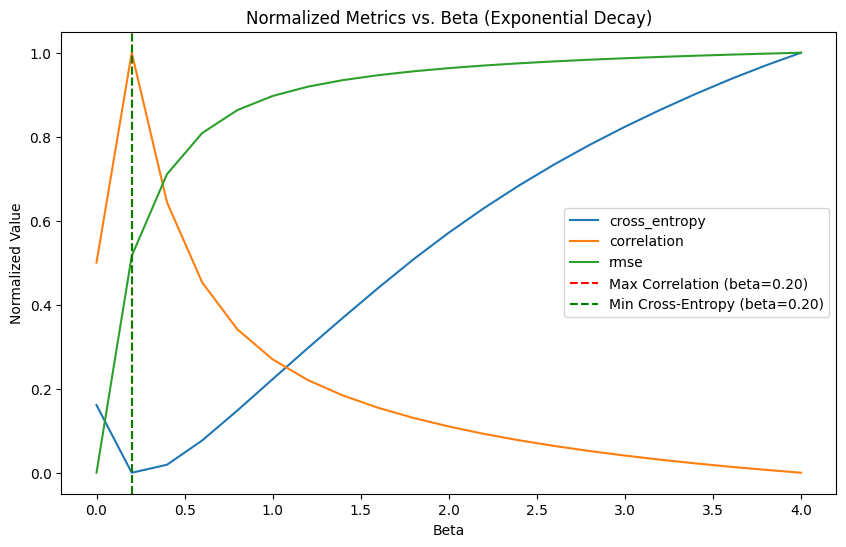

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Select columns to normalize
metrics_to_normalize = ['cross_entropy', 'correlation', 'rmse']
results_normalized = results.copy()

# Apply Min-Max Normalization
scaler = MinMaxScaler()
results_normalized[metrics_to_normalize] = scaler.fit_transform(results[metrics_to_normalize])

# Melt the DataFrame for plotting
results_melted = results_normalized.melt(
    id_vars=['beta'],
    value_vars=metrics_to_normalize,
    var_name='Metric',
    value_name='Normalized Value'
)

# Find beta for max correlation and min cross-entropy
max_correlation_beta = results_normalized.loc[results_normalized['correlation'].idxmax()]['beta']
min_cross_entropy_beta = results_normalized.loc[results_normalized['cross_entropy'].idxmin()]['beta']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_melted, x='beta', y='Normalized Value', hue='Metric')

# Add vertical lines
plt.axvline(max_correlation_beta, color='red', linestyle='--', label=f'Max Correlation (beta={max_correlation_beta:.2f})')
plt.axvline(min_cross_entropy_beta, color='green', linestyle='--', label=f'Min Cross-Entropy (beta={min_cross_entropy_beta:.2f})')


plt.title('Normalized Metrics vs. Beta (Exponential Decay)')
plt.xlabel('Beta')
plt.ylabel('Normalized Value')
plt.grid(False)
plt.legend()
plt.show()

## 4.2 Solve Beta with Adam

In [63]:
# Optimize parameters using Adam optimizer
optimization_result = model.solve_beta(
    metric='cross_entropy',
    method='adam',
    num_epochs=600
)

In [64]:
optimization_result

{'optimal_beta': np.float64(0.23913842786657635),
 'param2': 1.0,
 'optimization_success': True,
 'optimization_message': 'Adam optimization completed after 600 epochs',
 'final_metrics': {'cross_entropy': np.float64(8.545687536383733),
  'correlation': np.float64(0.7414789937429234),
  'rmse': np.float64(2476.709146355928),
  'mse': np.float64(6134088.195643111),
  'mae': np.float64(504.26644183187835)},
 'fij': array([1.79969637e+04, 1.22739452e+01, 3.85385458e+02, ...,
        2.98178685e-03, 1.31482265e+03, 1.49957490e+02]),
 'tij': array([6.81665749e+01, 1.61113773e-02, 4.39504249e-01, ...,
        4.17604281e-06, 1.33703830e+00, 8.51229011e+01])}

In [65]:
print(f"Best beta: {optimization_result['optimal_beta']}")
print(f"cross_entropy: {optimization_result['final_metrics']['cross_entropy']}")
print(f"correlation: {optimization_result['final_metrics']['correlation']}")

Best beta: 0.23913842786657635
cross_entropy: 8.545687536383733
correlation: 0.7414789937429234


# 5 R2SFCA model with additonal parameters

## Step 1 Initialize the R2SFCA model-with decay funtions using 2nd Parameter
single parameter:exponential, power, sqrt_exponential, log_squared

with 2nd parameter: sigmoid,gaussian,

In [70]:
from r2sfca import R2SFCA
# Initialize the R2SFCA model
model = R2SFCA(
    df=df,
    demand_col='Demand',
    supply_col='Supply',
    travel_cost_col='TravelCost',
    demand_id_col='DemandID',
    supply_id_col='SupplyID',
    # observed_flow_col='O_Fij',  # Optional, for validation
    decay_function='gaussian'
)

## Step 2 Solve beta by using minimize cross entropy- specify range

In [71]:
# Optimize parameters using minimize
optimization_minimize = model.solve_beta(
    metric='cross_entropy',
    param2=20.0,
    method='minimize'
)

In [72]:
print(f"Best beta: {optimization_minimize['optimal_beta']}")
print(f"cross_entropy: {optimization_minimize['final_metrics']['cross_entropy']}")
print(f"correlation: {optimization_minimize['final_metrics']['correlation']}")

Best beta: 2.9425712289385526
cross_entropy: 8.527467318404392
correlation: 0.7999594978195459


In [78]:
for d0 in [10,20,30,40,50]:
  # Optimize parameters using minimize
  optimization_s = model.solve_beta(
      metric='cross_entropy',
      param2=d0 ,
      method='minimize'
  )
  print(f"d0: {d0} ; Best beta: {  optimization_s['optimal_beta']};cross_entropy: { optimization_s['final_metrics']['cross_entropy']}")


d0: 10 ; Best beta: 0.7356494683241804;cross_entropy: 8.527467318382236
d0: 20 ; Best beta: 2.9425712289385526;cross_entropy: 8.527467318404392
d0: 30 ; Best beta: 6.620834370805815;cross_entropy: 8.52746731838302
d0: 40 ; Best beta: 10.0;cross_entropy: 8.533891574209992
d0: 50 ; Best beta: 10.0;cross_entropy: 8.609481162092901


## Step 2a Perform grid search to find optimal parameters

In [80]:
results = model.search_fij(
    beta_range=(0.0, 4.0, 0.2),
    param2_range = (10, 20.0, 5.0),
    metrics=['cross_entropy', 'correlation', 'rmse']
)

In [87]:
results

,beta,param2,decay_function,cross_entropy,correlation,rmse
0,0.0,10.0,gaussian,10.300858,0.572661,739.376328
1,0.0,15.0,gaussian,10.300858,0.572661,739.376328
2,0.0,20.0,gaussian,10.300858,0.572661,739.376328
3,0.2,10.0,gaussian,8.846273,0.900158,1767.798977
4,0.2,15.0,gaussian,9.172614,0.911304,1481.306635
...,...,...,...,...,...,...
58,3.8,15.0,gaussian,8.781636,0.698817,2856.083452
59,3.8,20.0,gaussian,8.547492,0.770610,2521.197725
60,4.0,10.0,gaussian,9.915971,0.579706,3301.468931
61,4.0,15.0,gaussian,8.817928,0.691964,2885.817824


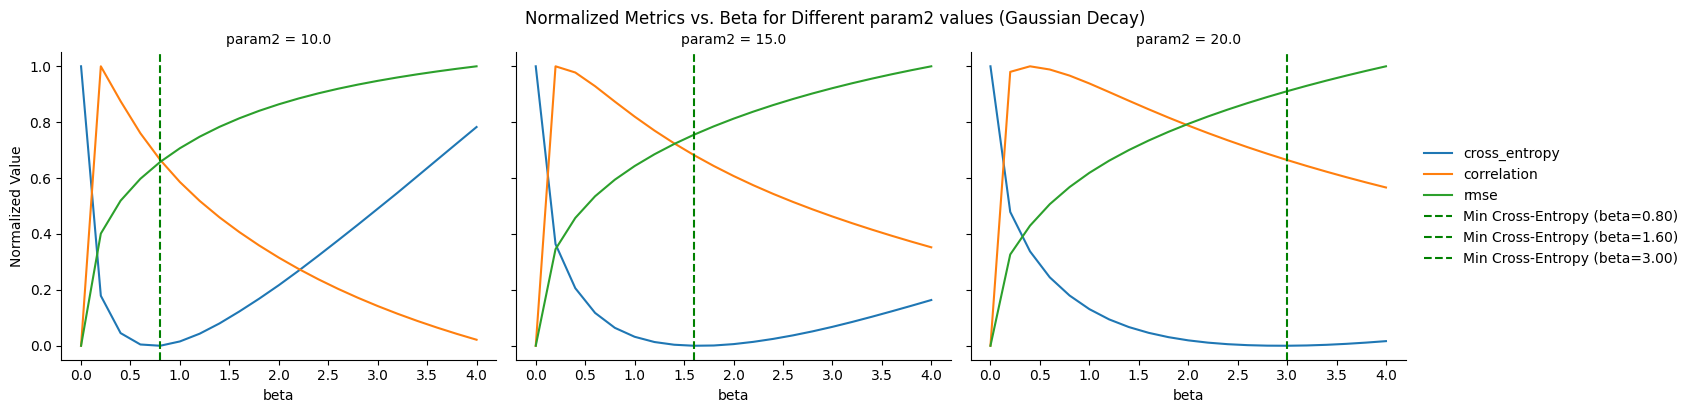

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Select columns to normalize
metrics_to_normalize = ['cross_entropy', 'correlation', 'rmse']
results_normalized = results.copy()

# Apply Min-Max Normalization within each param2 group by iterating
for param2_val in results_normalized['param2'].unique():
    subset_index = results_normalized['param2'] == param2_val
    scaler = MinMaxScaler()
    results_normalized.loc[subset_index, metrics_to_normalize] = scaler.fit_transform(results_normalized.loc[subset_index, metrics_to_normalize])


# Melt the DataFrame for plotting
results_melted = results_normalized.melt(
    id_vars=['beta', 'param2'],
    value_vars=metrics_to_normalize,
    var_name='Metric',
    value_name='Normalized Value'
)

# Create a FacetGrid for subplots
g = sns.FacetGrid(results_melted, col="param2", col_wrap=3, height=4, aspect=1.2)

# Define a function to add vertical lines for minimum cross-entropy
def add_min_cross_entropy_vline(x, y, hue, **kwargs):
    # Create a temporary DataFrame from the passed data
    temp_df = pd.DataFrame({'beta': x, 'Normalized Value': y, 'Metric': hue})
    min_ce_beta = temp_df.loc[temp_df['Metric'] == 'cross_entropy'].loc[temp_df.loc[temp_df['Metric'] == 'cross_entropy']['Normalized Value'].idxmin()]['beta']
    plt.axvline(min_ce_beta, color='green', linestyle='--', label=f'Min Cross-Entropy (beta={min_ce_beta:.2f})')
    plt.legend()


g.map(sns.lineplot, "beta", "Normalized Value", "Metric")
g.map(add_min_cross_entropy_vline, 'beta', 'Normalized Value', 'Metric') # Map the function to each subplot
g.add_legend()
g.fig.suptitle('Normalized Metrics vs. Beta for Different param2 values (Gaussian Decay)', y=1.02)
plt.show()

# 6 Other functions

## 6.1 plot_grid_search_results

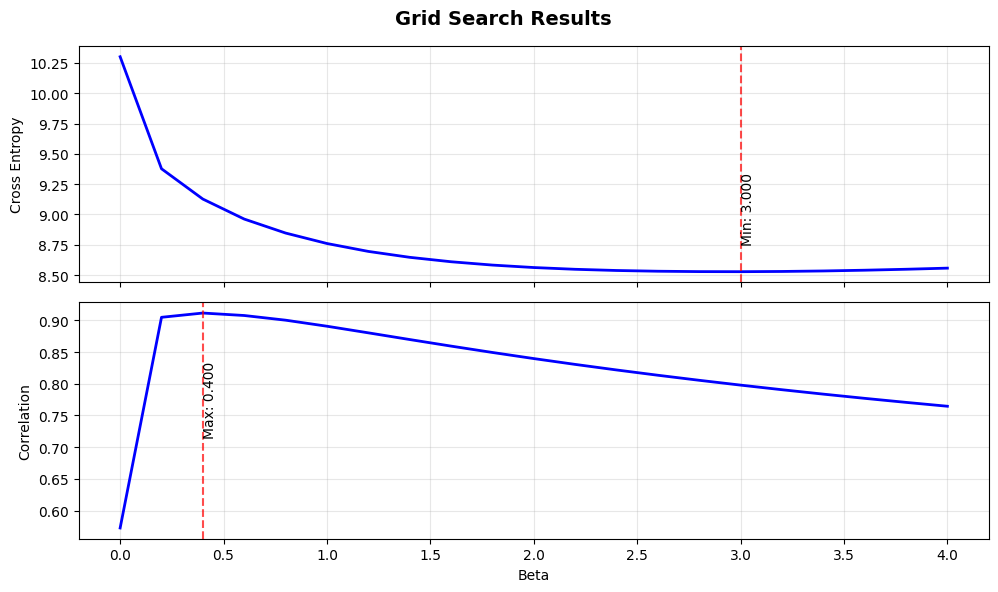

In [91]:
from r2sfca.utils import plot_grid_search_results

# Plot grid search results
fig = plot_grid_search_results(
    results_df=results[results['param2'] == 20],
    x_col='beta',
    y_cols=['cross_entropy', 'correlation'],
    title='Grid Search Results',
    save_path='grid_search.png'
)

## 6.2 plot_model_comparison

In [102]:
def searchall(functionlist=['gaussian', 'exponential', 'power']):
  results_dfs=[]
  for func in functionlist:

      model = R2SFCA(
          df=df,
          demand_col='Demand',
          supply_col='Supply',
          travel_cost_col='TravelCost',
          demand_id_col='DemandID',
          supply_id_col='SupplyID',
          observed_flow_col='O_Fij',  # Optional, for validation
          decay_function=func
      )
      resultsn = model.search_fij(
          beta_range=(0.0, 4.0, 0.2),
          param2_range = 20,
          metrics=['cross_entropy', 'correlation', 'fij_flow_correlation']
      )
      results_dfs.append(resultsn) # Append the dataframe to the list
  return results_dfs

In [ ]:
results_dfs=searchall()

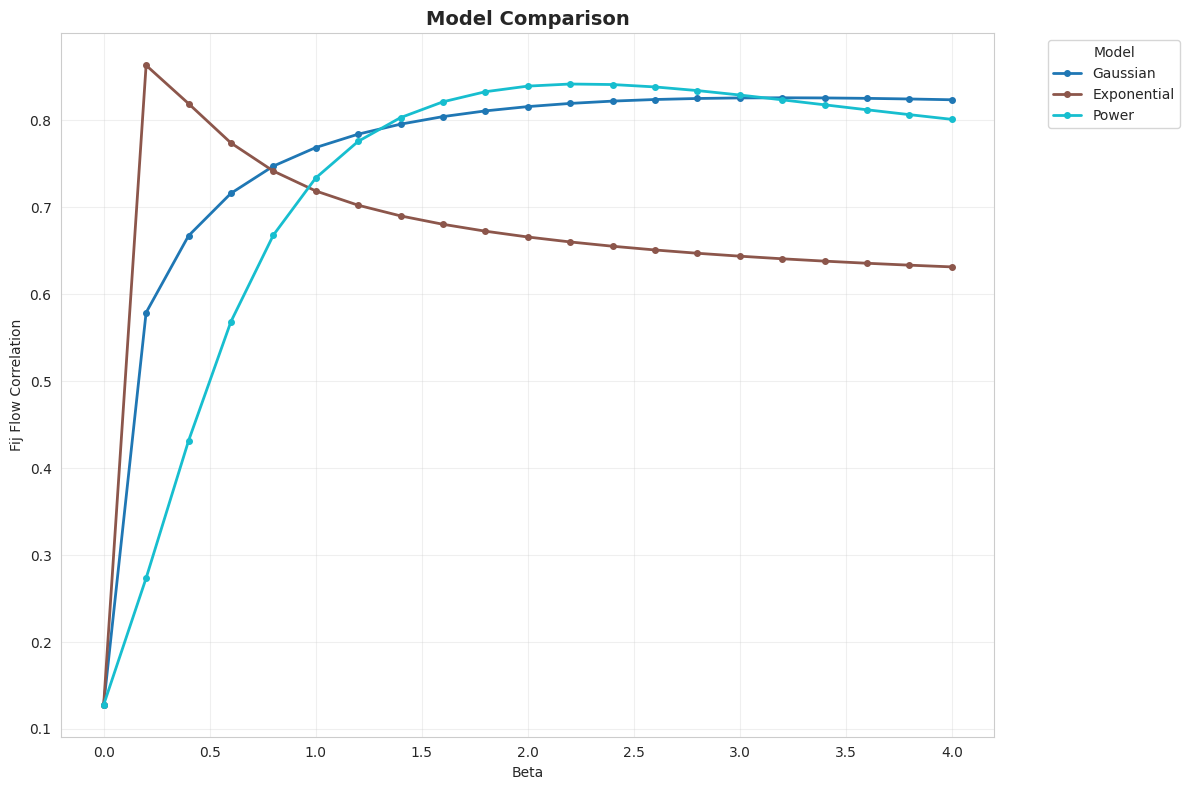

In [107]:
from r2sfca.utils import plot_model_comparison
list=['Gaussian', 'Exponential', 'Power']
# Compare multiple models
fig = plot_model_comparison(
    results_dfs=results_dfs,
    labels=list,
    y_col='fij_flow_correlation',
    title='Model Comparison',
    save_path='model_comparison.png'
)


## 6.3 create_summary_table

In [108]:
from r2sfca.utils import create_summary_table

# Create summary table
summary = create_summary_table(
    results_dfs=results_dfs,
    labels=list,
    metric='cross_entropy',
    minimize=True
)

In [109]:
summary

,Model,Optimal_Beta,Optimal_cross_entropy,Optimal_Param2,correlation,fij_flow_correlation
0,Gaussian,3.0,8.527489,20,0.797813,0.825624
1,Exponential,0.2,8.563250,20,0.777820,0.863145
2,Power,2.6,9.250782,20,0.644240,0.838273
